In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import seaborn as sns
from tqdm import trange
import xarray as xr

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.diverging'] = 'vlag'
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
dims = ['alpha_x', 'alpha_y', 'beta_x', 'beta_y']
eps_labels = [r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$']
twiss_labels = [r'$\alpha_x$', r'$\alpha_y$', r'$\beta_x$', r'$\beta_y$']  
twiss_labels_dict = {dim: label for dim, label in zip(dims, twiss_labels)}

Load the data.

In [4]:
alpha_xs = np.loadtxt('_output/data/alpha_xs.dat')
alpha_ys = np.loadtxt('_output/data/alpha_ys.dat')
beta_xs = np.loadtxt('_output/data/beta_xs.dat')
beta_ys = np.loadtxt('_output/data/beta_ys.dat')
alpha_x_true, alpha_y_true, beta_x_true, beta_y_true = np.loadtxt('_output/data/true_twiss.dat')
eps_x_true, eps_y_true, eps_1_true, eps_2_true = 1e6 * np.loadtxt('_output/data/true_emittances.dat')
eps_true = np.array([eps_x_true, eps_y_true, eps_1_true, eps_2_true])

In [6]:
def load_pickled_file(filename):
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data

def load_data(filename):
    data = load_pickled_file(filename)
    data = np.array(data)
    data *= 1e6
    data = xr.DataArray(
        data, 
        dims=dims+['emittance'], 
        coords={'alpha_x': alpha_xs, 
                'alpha_y': alpha_ys, 
                'beta_x': beta_xs, 
                'beta_y': beta_ys}
    )
    return data

In [46]:
means = [load_data(f'_output/data/emittance_means_{i}.pkl') for i in range(4)]
stds = [load_data(f'_output/data/emittance_stds_{i}.pkl') for i in range(4)]
fail_rates = [load_pickled_file(f'_output/data/fail_rates_{i}.pkl') for i in range(4)]
for i in range(len(fail_rates)):
    fail_rates[i] = xr.DataArray(
        fail_rates[i],
        dims=dims,
        coords={
            'alpha_x': alpha_xs, 
            'alpha_y': alpha_ys, 
            'beta_x': beta_xs, 
            'beta_y': beta_ys
        },
    )
frac_stds = [stds[i] / eps_true[i] for i in range(4)]
errs = [eps_true[i] - means[i] for i in range(4)]
frac_errs = [errs[i] / eps_true[i] for i in range(4)]
frac_stds = [stds[i] / eps_true[i] for i in range(4)]

Plot.

In [47]:
n = len(beta_xs)

In [48]:
def mismatch_parameter(alpha1, beta1, alpha2, beta2):
    gamma1 = (1.0 + alpha1**2) / beta1
    gamma2 = (1.0 + alpha2**2) / beta2
    return 0.5 * (beta1 * gamma2 - 2.0 * alpha1 * alpha2 + gamma1 * beta2)

In [49]:
Mx = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
My = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
for i, alpha_x in enumerate(alpha_xs):
    for k, beta_x in enumerate(beta_xs):
        for j, alpha_y in enumerate(alpha_ys):
            for l, beta_y in enumerate(beta_ys): 
                Mx[i, j, k, l] = mismatch_parameter(alpha_x, beta_x, alpha_x_true, beta_x_true)
                My[i, j, k, l] = mismatch_parameter(alpha_y, beta_y, alpha_y_true, beta_y_true)
M = Mx + My

In [50]:
def correct_xlim(ax):
    xlim = ax.get_xlim()
    if xlim[1] < xlim[0]:
        ax.set_xlim(list(reversed(ax.get_xlim())))

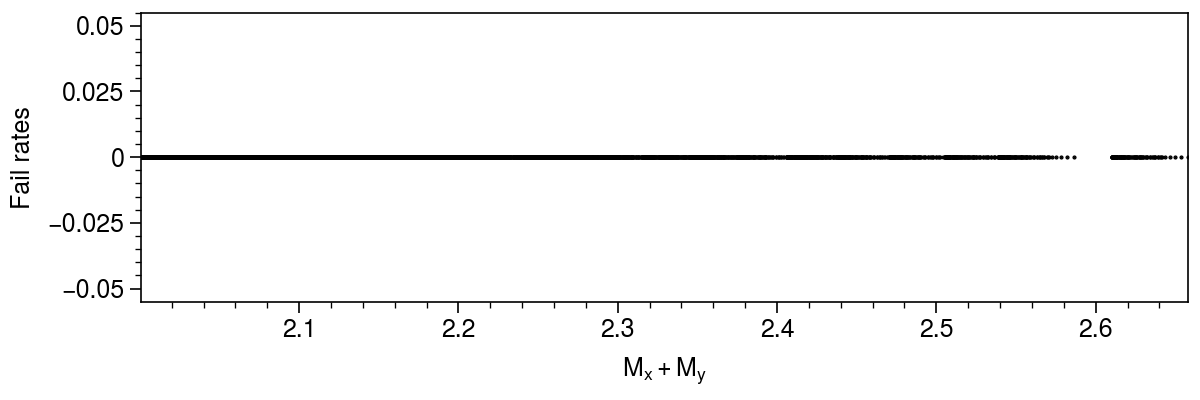

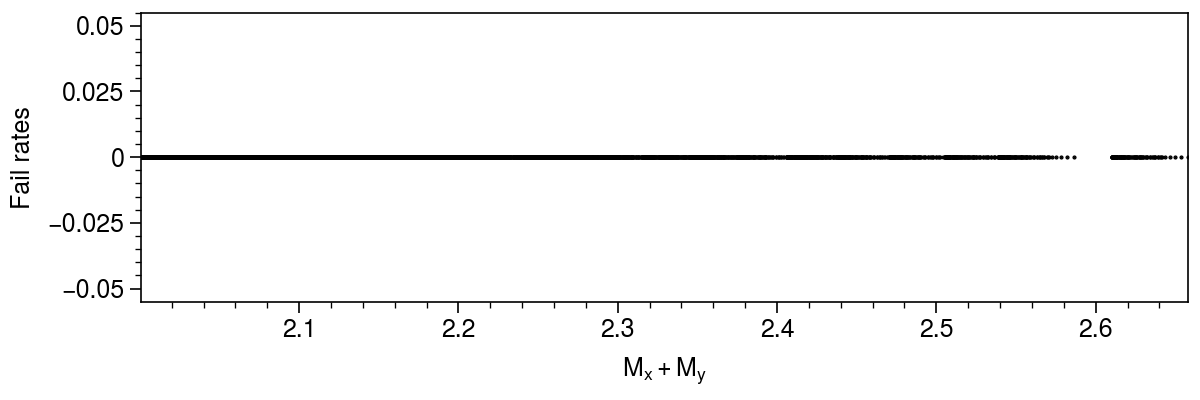

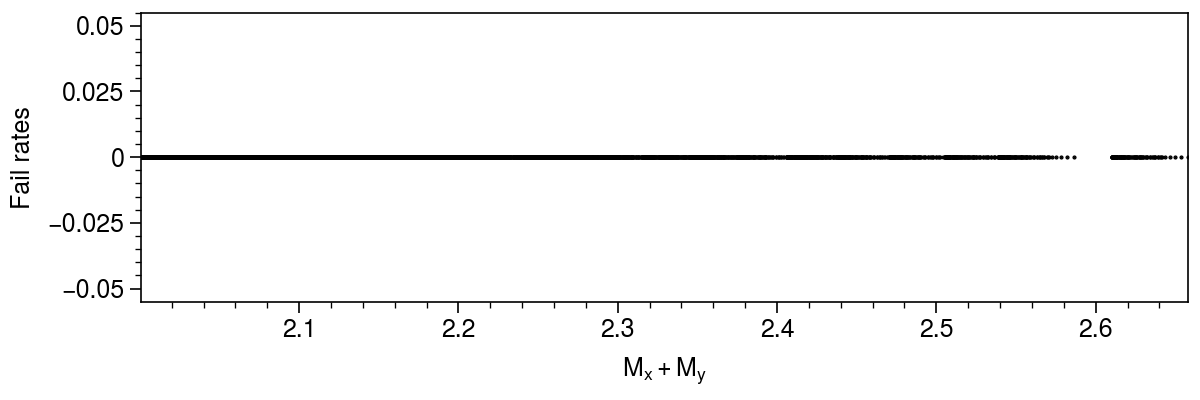

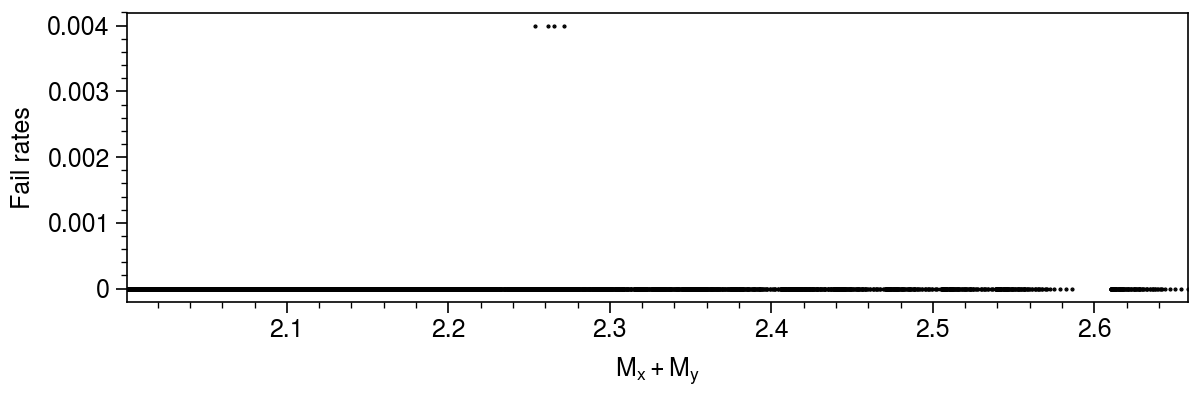

In [62]:
for _fail_rates in fail_rates:
    fig, ax = pplt.subplots(figsize=(6.0, 2.0))
    ax.plot(M.ravel(), _fail_rates.values.ravel(), color='black', lw=0, marker='.', ms=1)
    ax.format(xlabel=r'$M_x + M_y$', ylabel='Fail rates')
    correct_xlim(ax)
    plt.show()

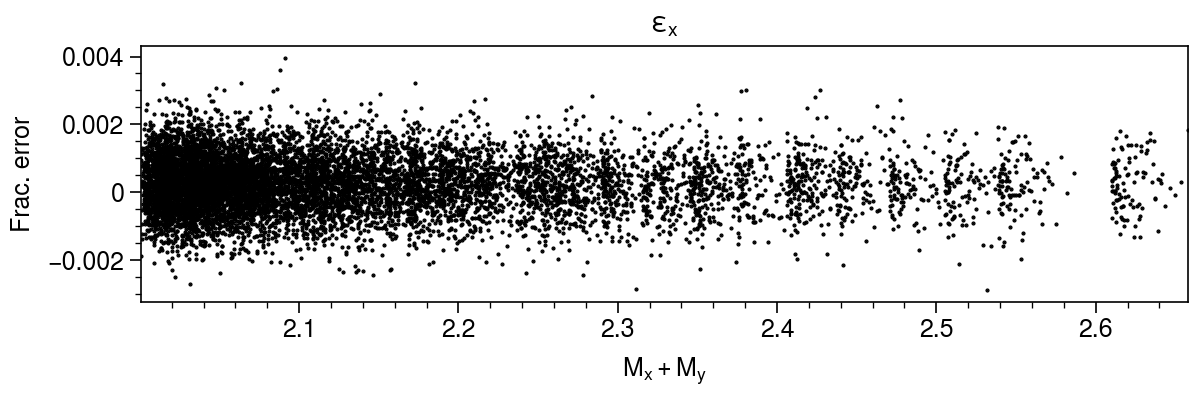

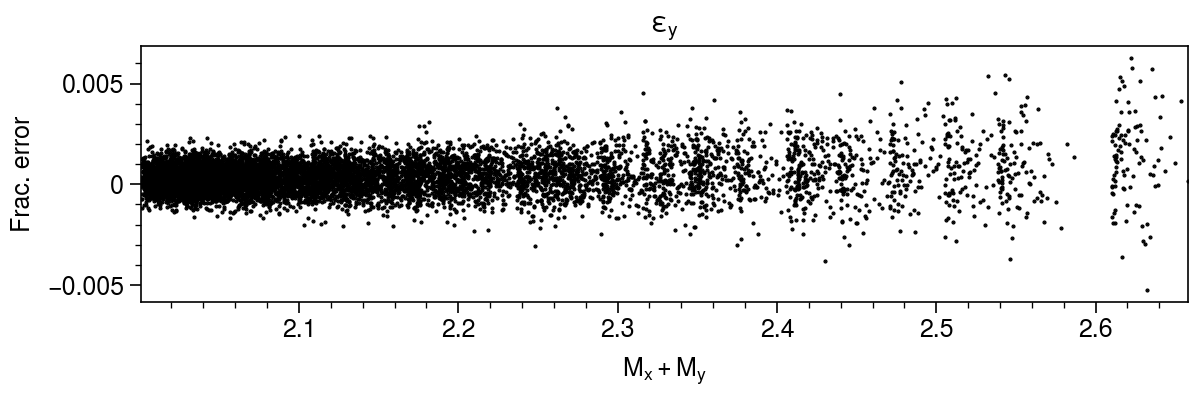

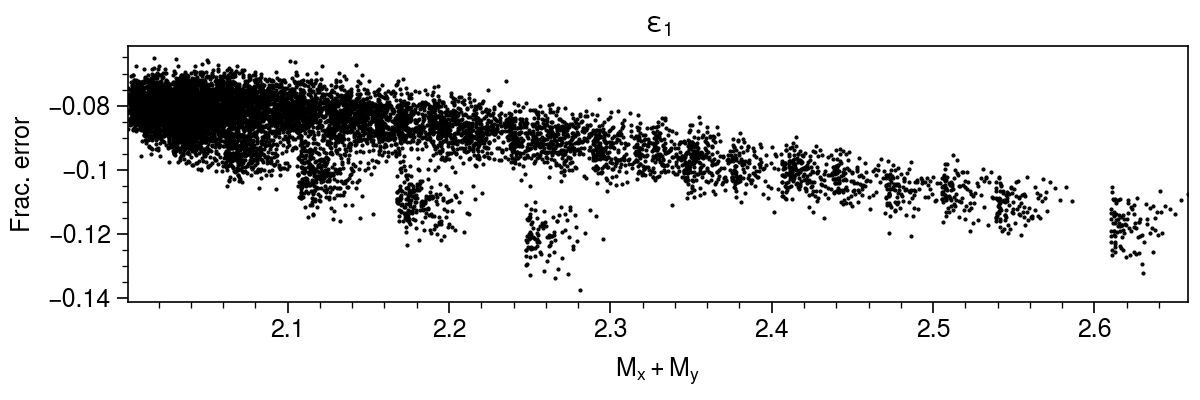

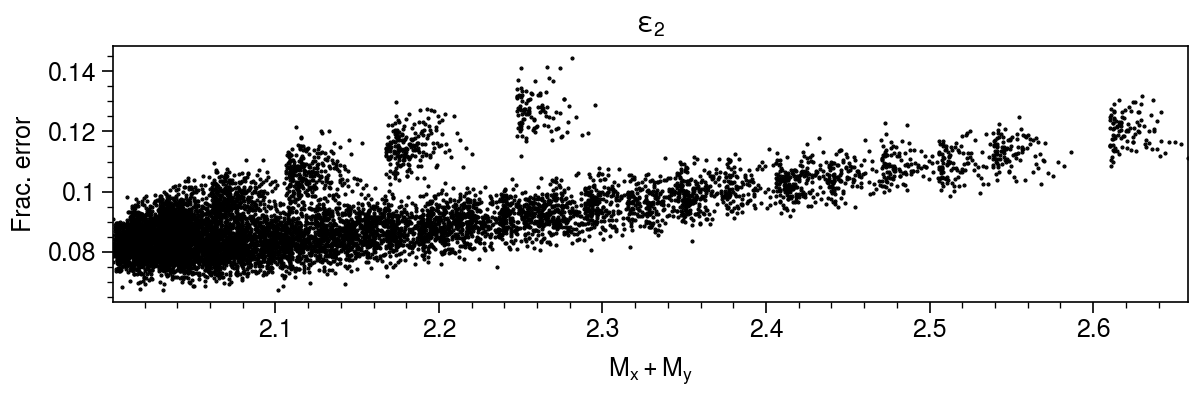

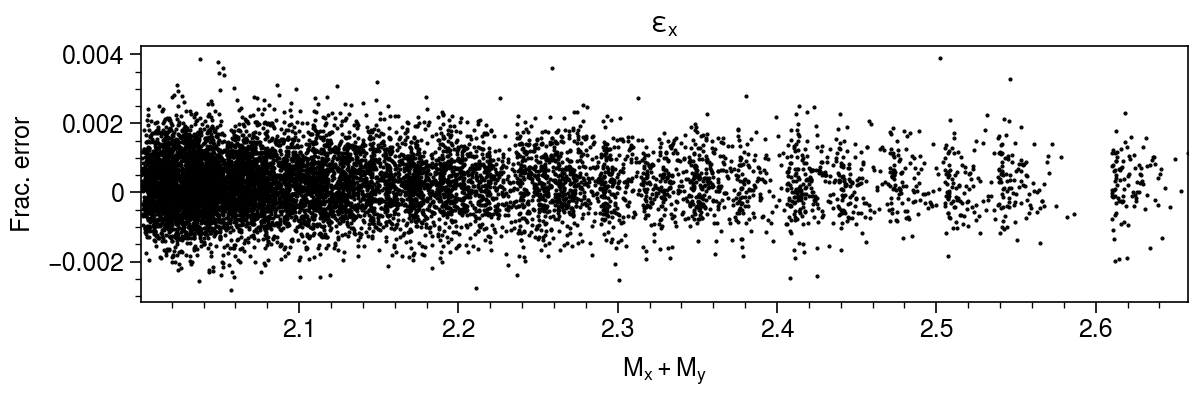

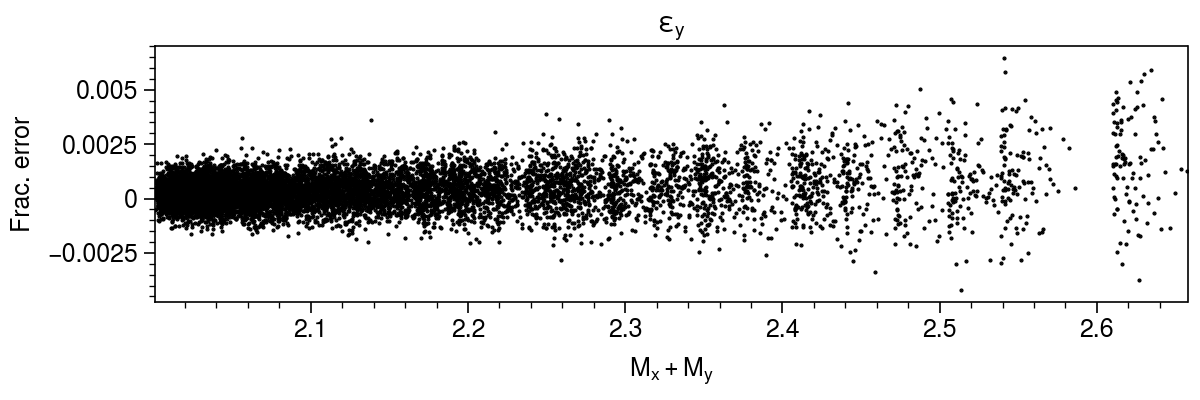

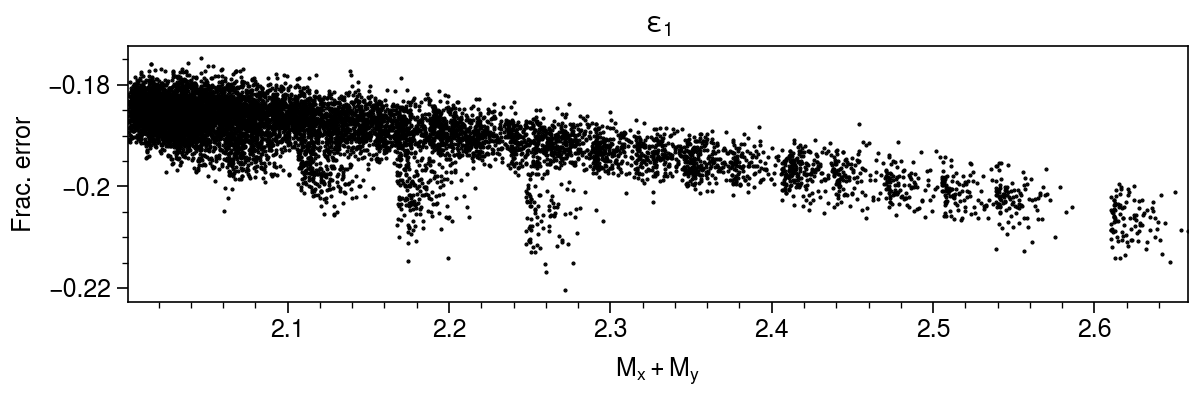

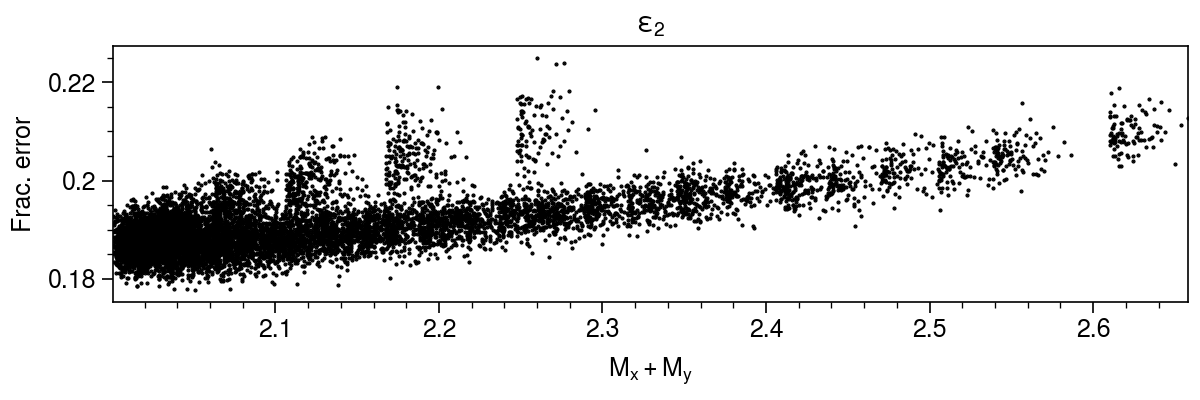

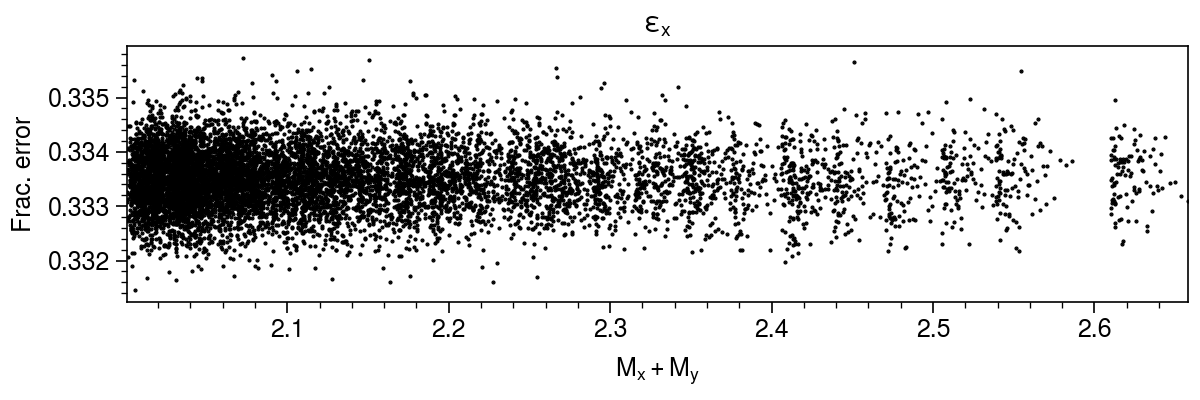

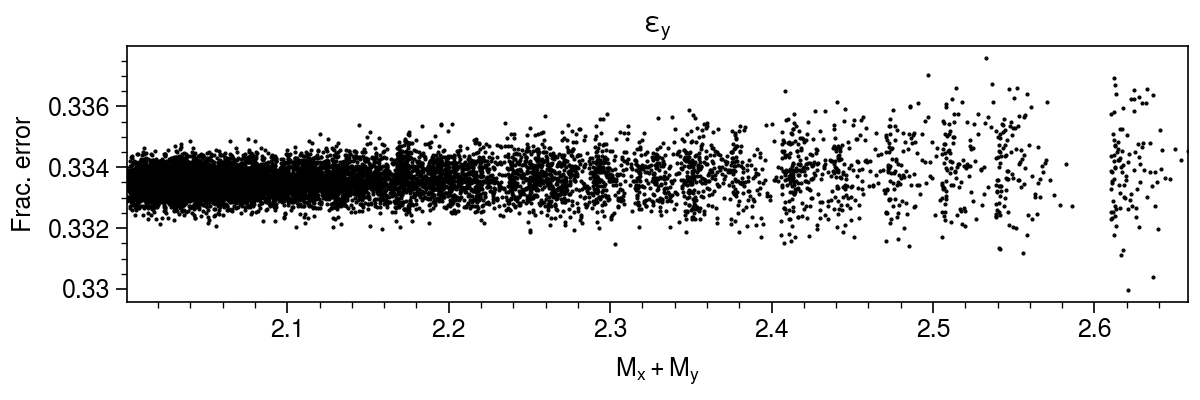

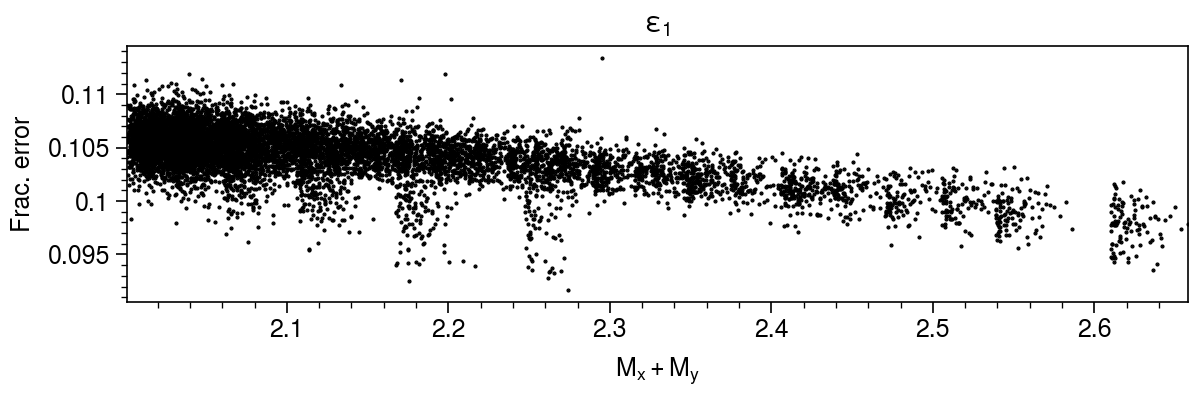

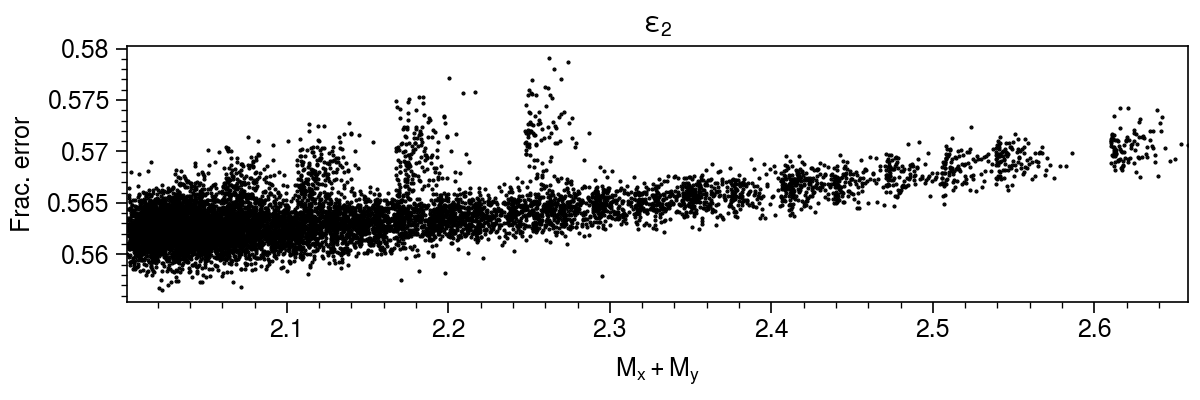

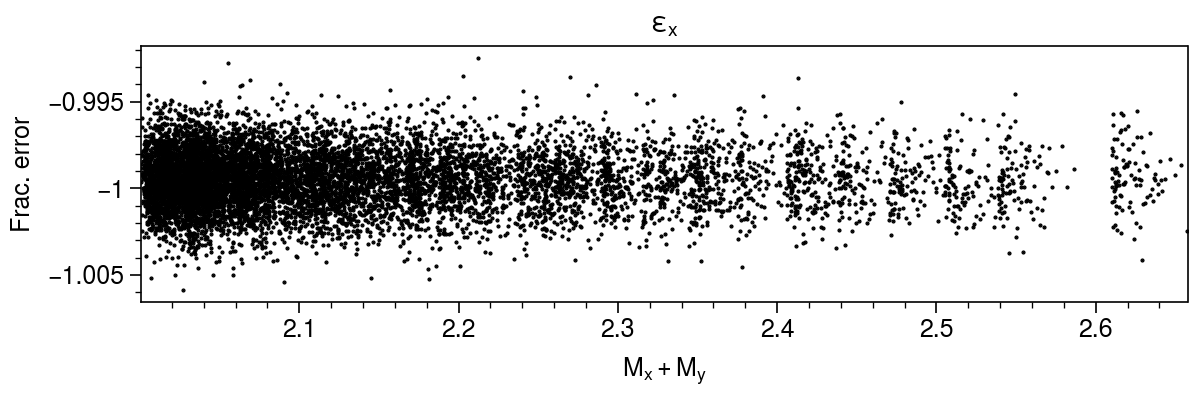

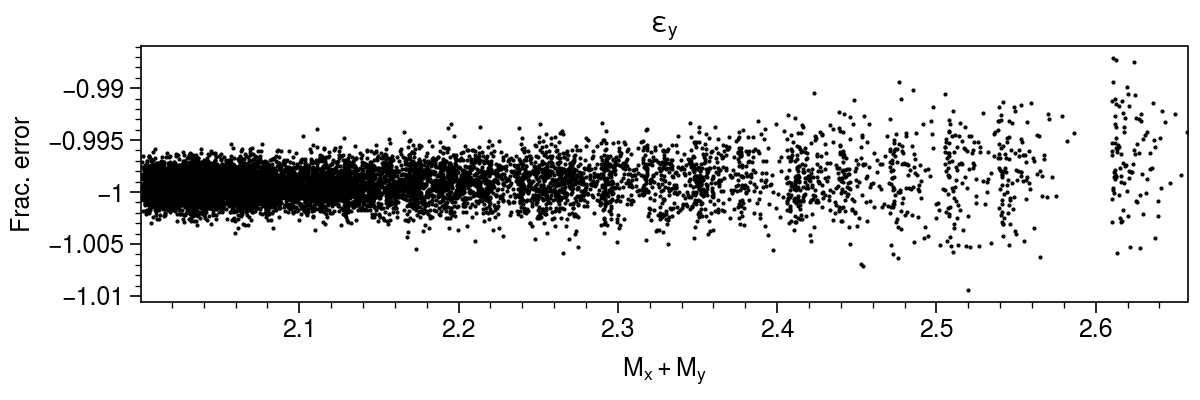

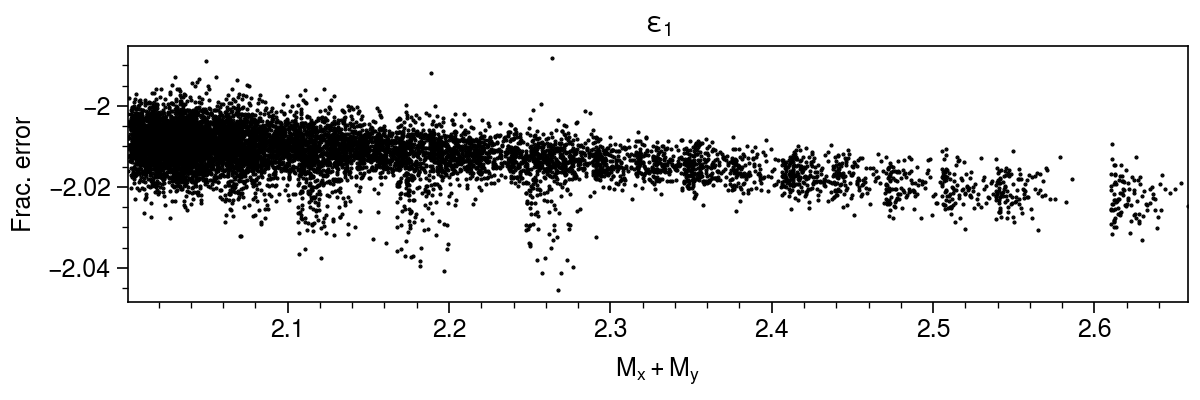

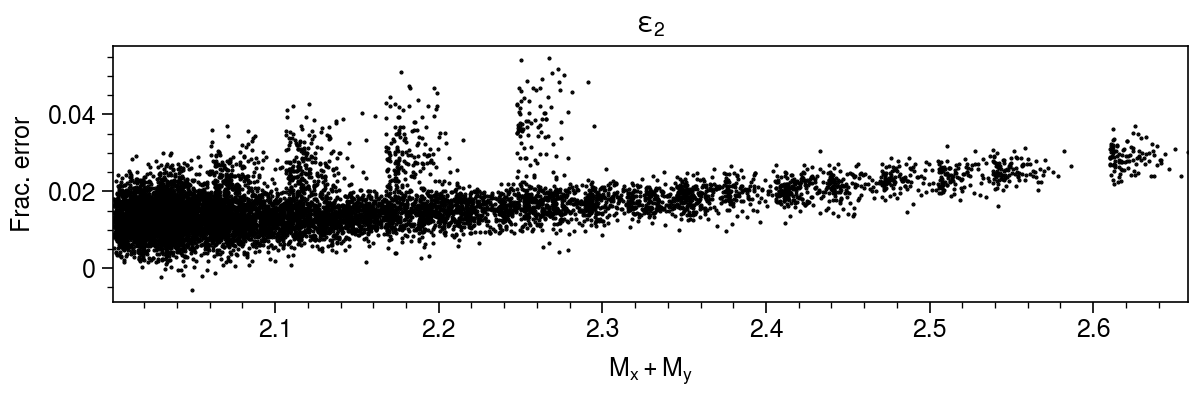

In [63]:
for _frac_errs in frac_errs:
    for i, eps_label in enumerate(eps_labels):
        fig, ax = pplt.subplots(figsize=(6.0, 2.0))
        ax.plot(M.ravel(), _frac_errs[..., i].values.ravel(), color='black', lw=0, marker='.', ms=1)
        ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. error', title=eps_label)
        correct_xlim(ax)
        plt.show()

In [64]:
cmap = pplt.Colormap('mono', left=0.4)

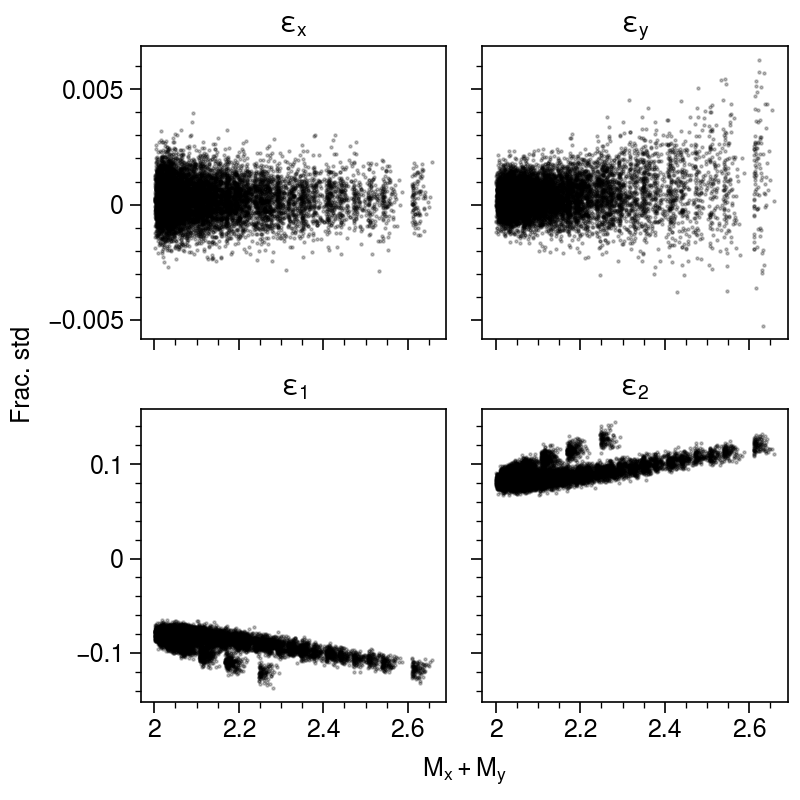

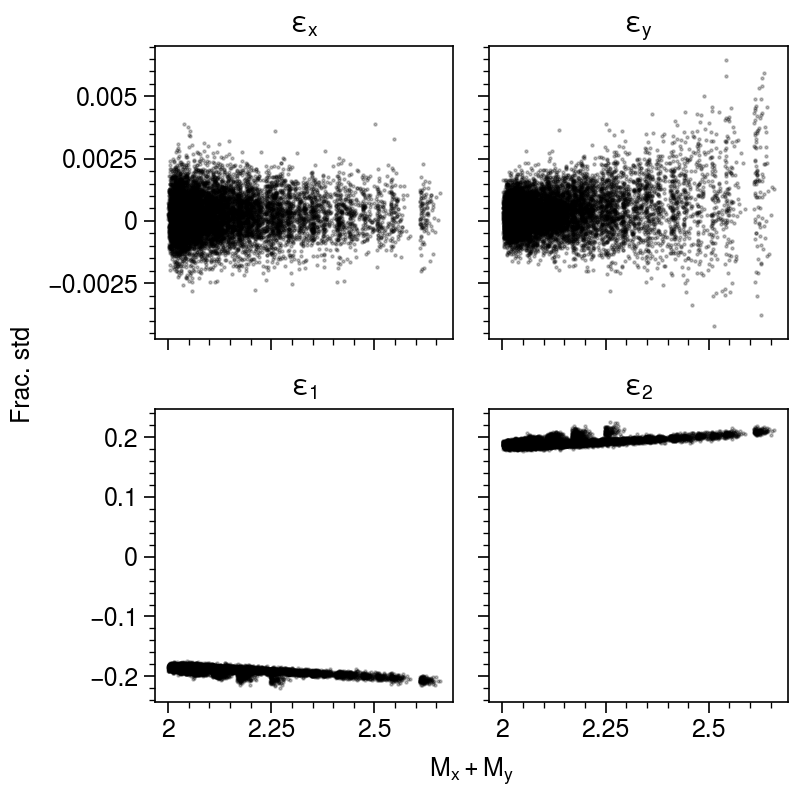

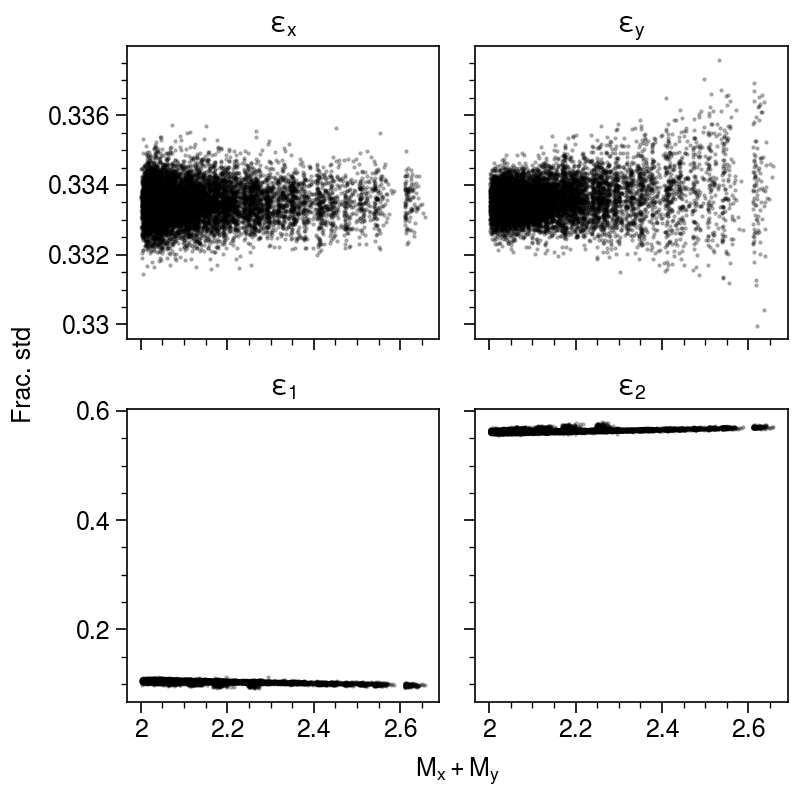

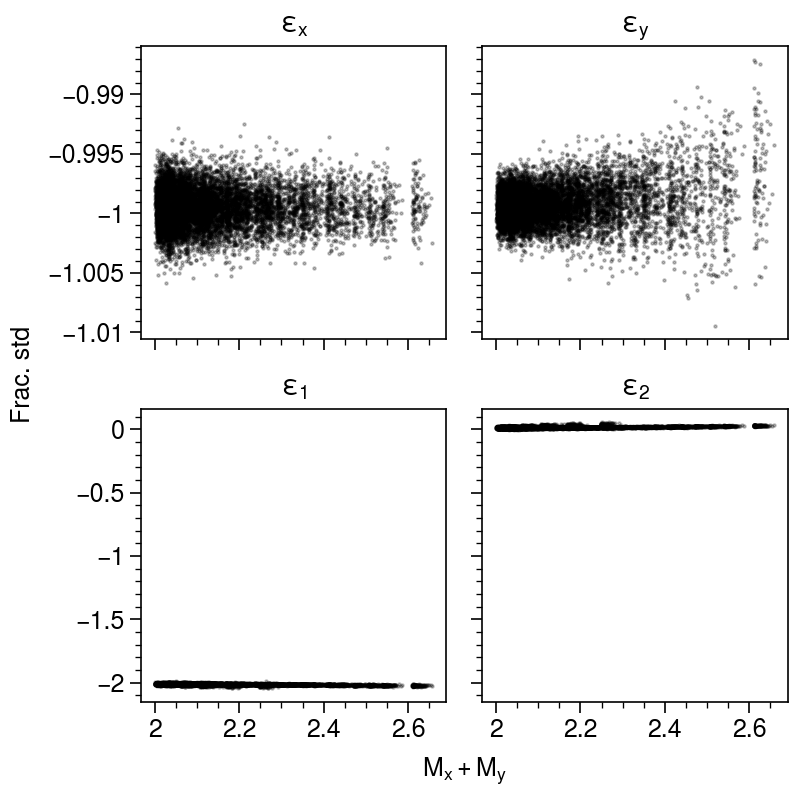

In [66]:
for _frac_errs in frac_errs:
    fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(4.0, 4.0))
    for i, (eps_label, ax) in enumerate(zip(eps_labels, axes)):
        x = M.ravel()
        y = _frac_errs[..., i].values.ravel()
        ax.scatter(x, y, c='black', s=1, alpha=0.25)
        ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. std', title=eps_label)
        correct_xlim(ax)
    plt.show()

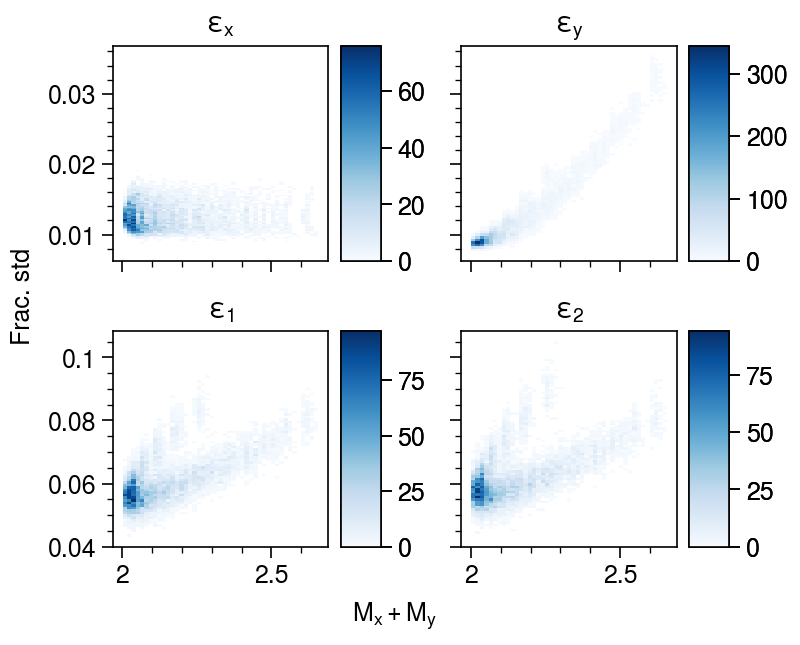

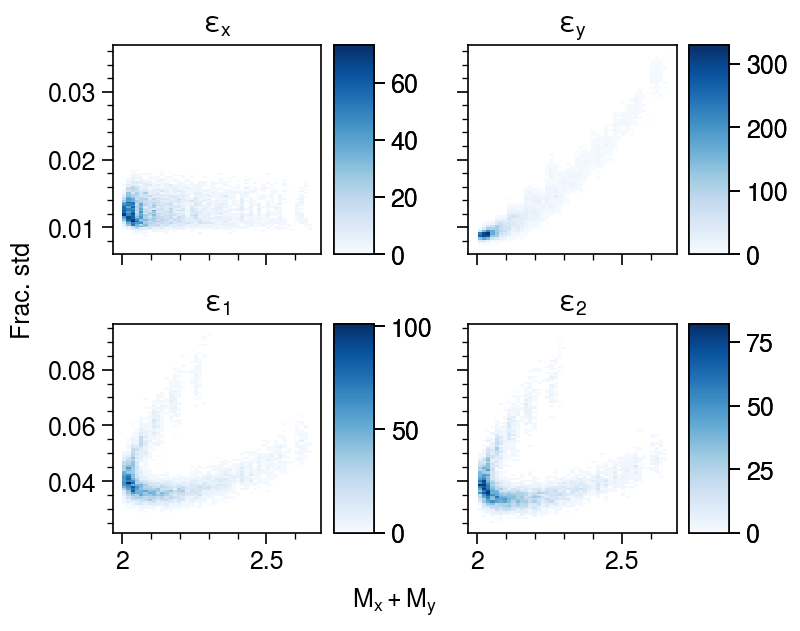

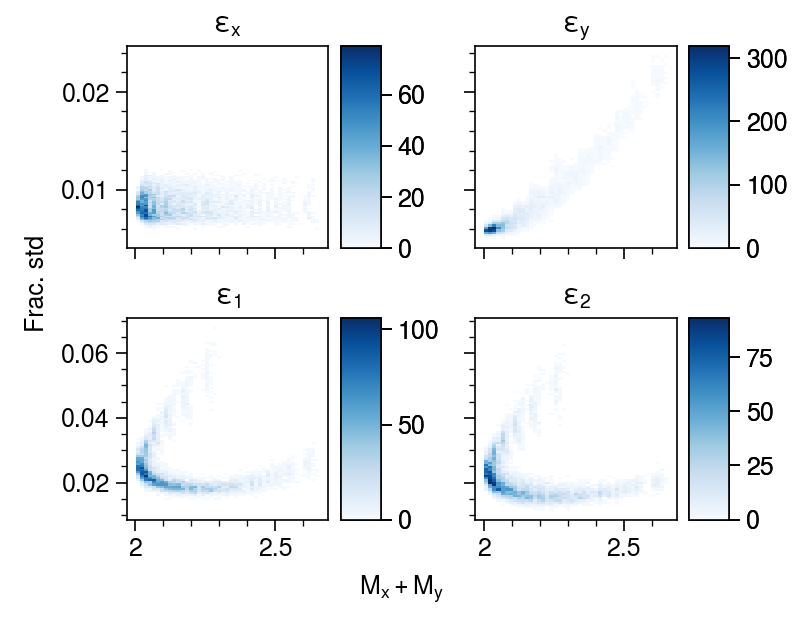

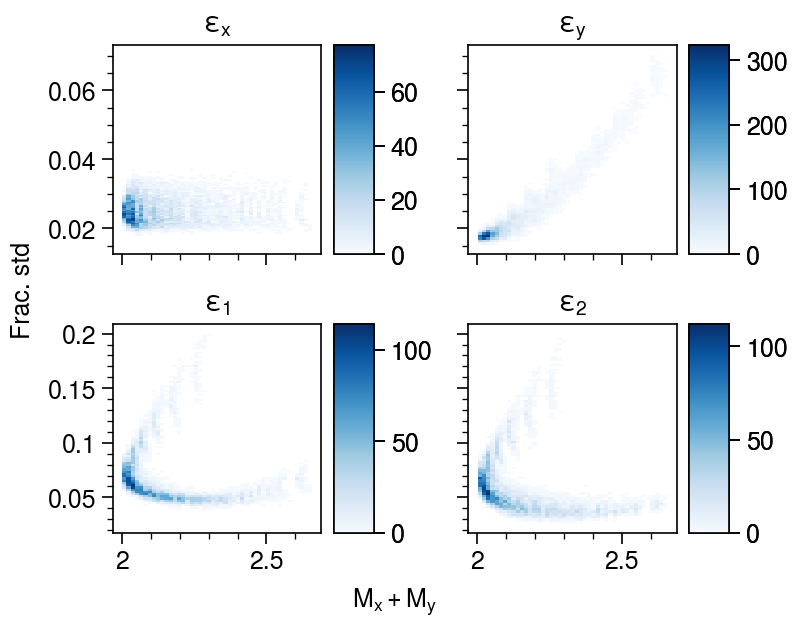

In [67]:
for _frac_stds in frac_stds:
    fig, axes = pplt.subplots(nrows=2, ncols=2, figwidth=4.0)
    for i, (eps_label, ax) in enumerate(zip(eps_labels, axes)):
        x = M.ravel()
        y = _frac_stds[..., i].values.ravel()
        sns.histplot(x=x, y=y, ax=ax, cmap='blues', ec='None', colorbar=True)
        ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. std', title=eps_label)
        correct_xlim(ax)
    plt.show()

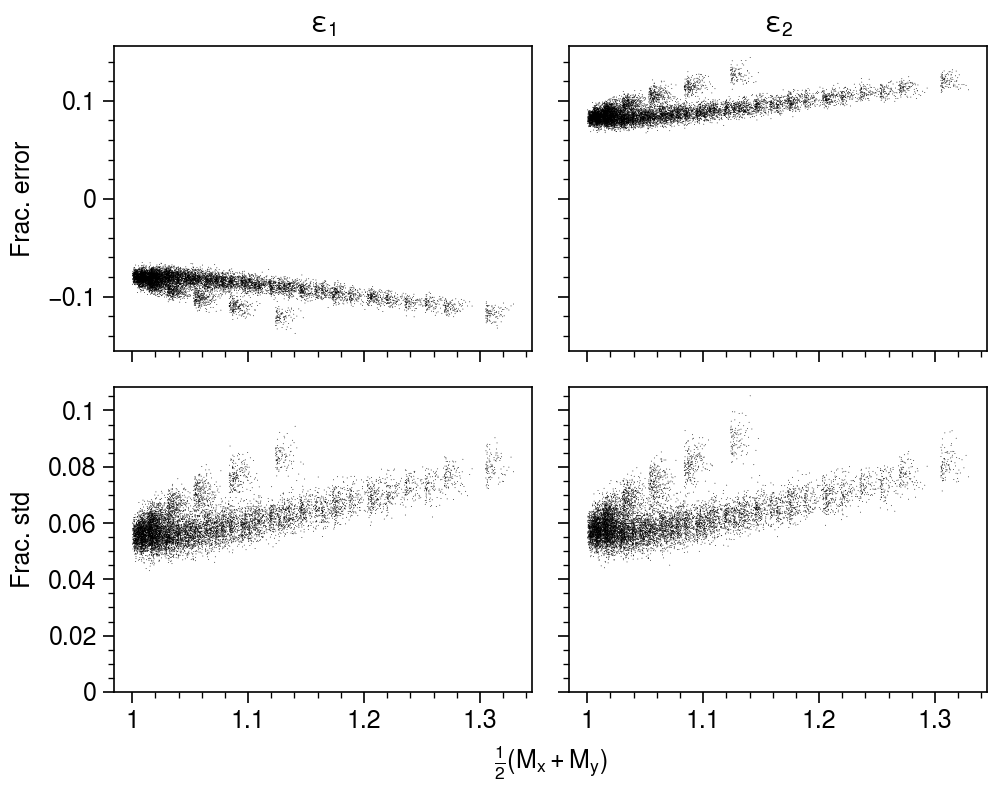

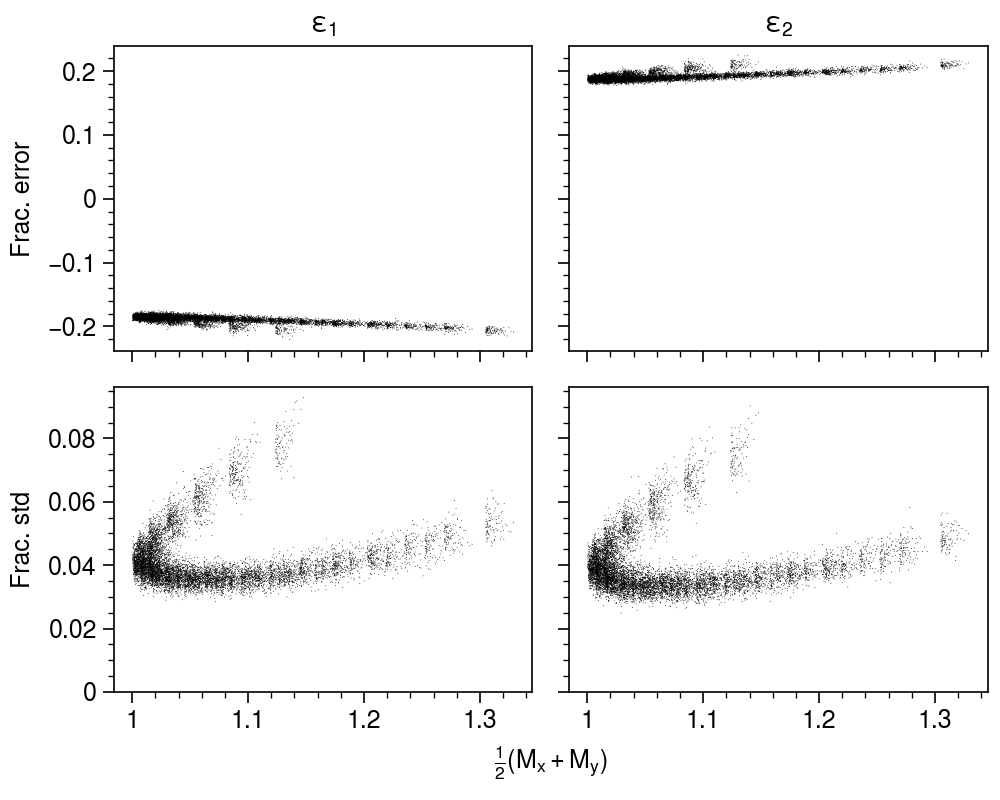

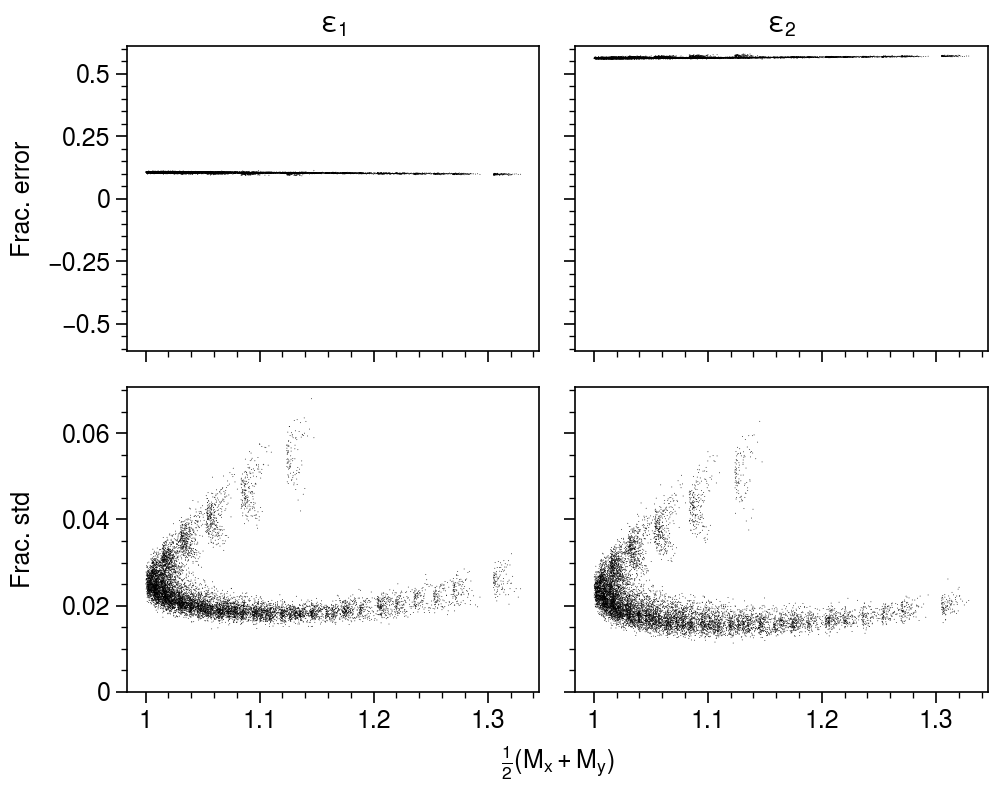

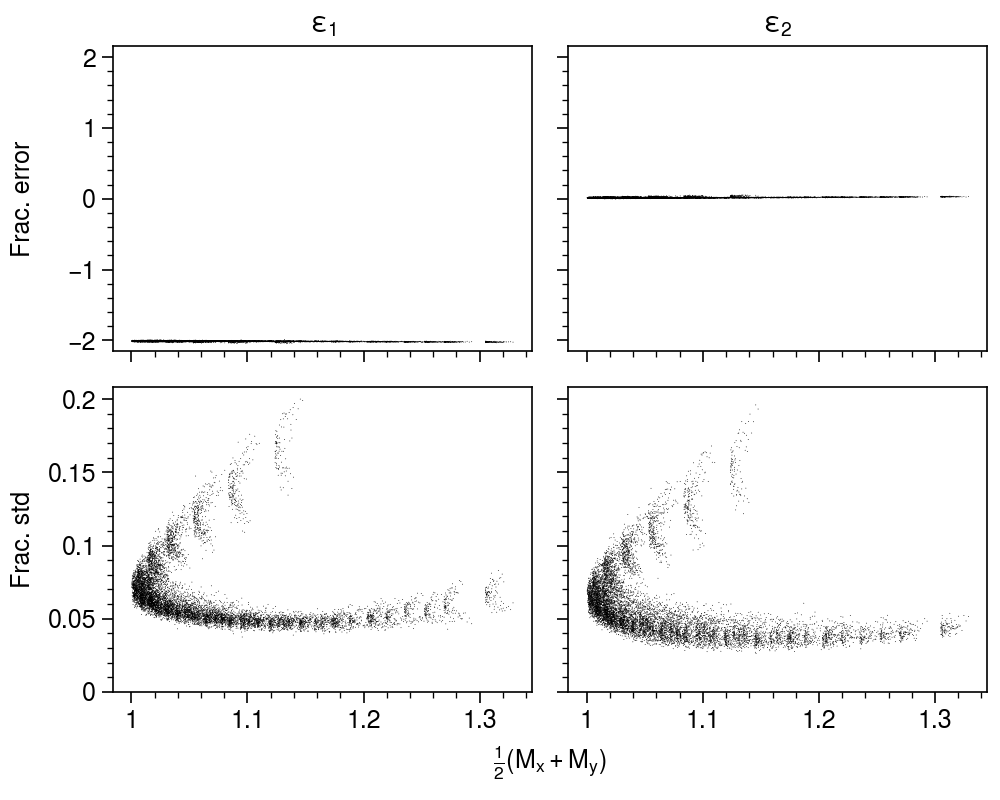

In [68]:
for k in range(4):
    fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0), 
                          sharey=False, spany=False, aligny=True)
    # kws = dict(c='black', s=10.0, ec='None', alpha=0.1)
    kws = dict(c='black', s=0.1, ec='None')
    x = 0.5 * M.ravel()
    for j in range(2):
        for i, data in enumerate([frac_errs[k], frac_stds[k]]):
            y = data[..., j + 2].values.ravel()
            axes[i, j].scatter(x, y, **kws)
    axes.format(xlabel=r'$\frac{1}{2} (M_x + M_y)$')
    axes[0, 0].format(ylabel='Frac. error')
    axes[1, 0].format(ylabel='Frac. std')

    ymax = np.max(np.abs([ax.get_ylim() for ax in axes[0, :]]))
    ymax *= 1.05
    # ymax = 0.15
    axes[0, :].format(ylim=(-ymax, ymax))

    ymax = np.max(np.abs([ax.get_ylim() for ax in axes[1, :]]))
    axes[1, :].format(ylim=(0.0, ymax))

    xlims = np.zeros((2, 2, 2))
    ylims = np.zeros((2, 2, 2))
    for i in range(2):
        for j in range(2):
            xlims[i, j] = axes[i, j].get_xlim()
            ylims[i, j] = axes[i, j].get_ylim()

    for ax, label in zip(axes[0, :], eps_labels[2:]):
        ax.set_title(label)
    axes[:, 1].format(yticklabels=[])
    plt.savefig(f'_output/figures/mismatch_{k}')
    plt.show()

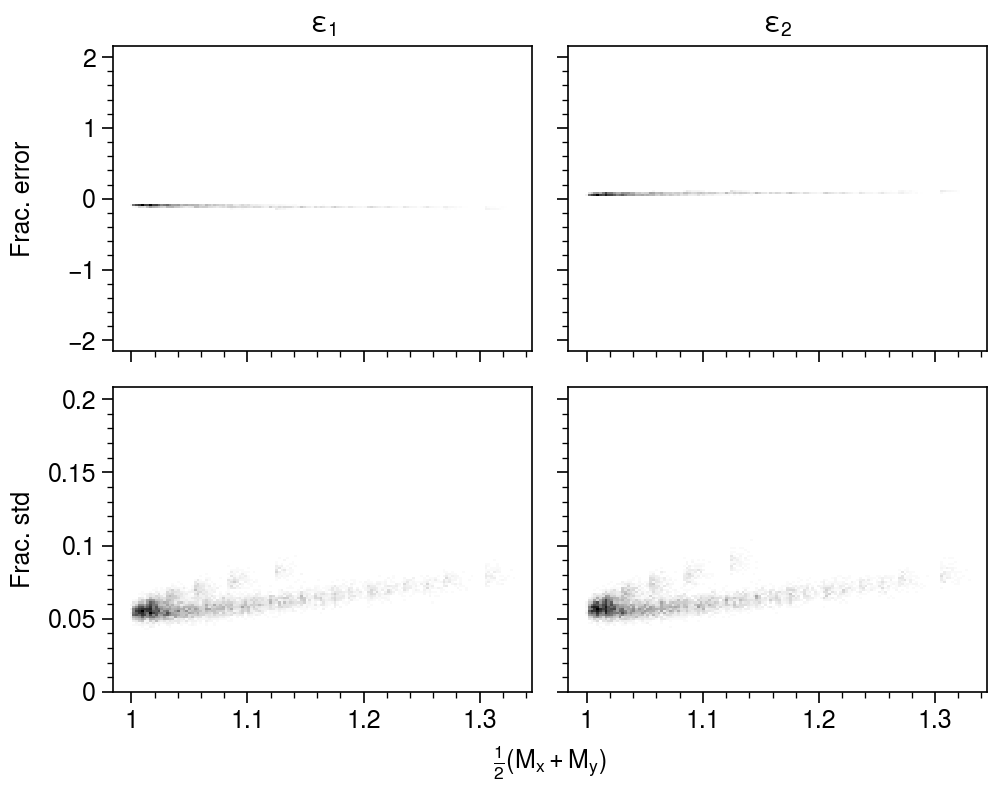

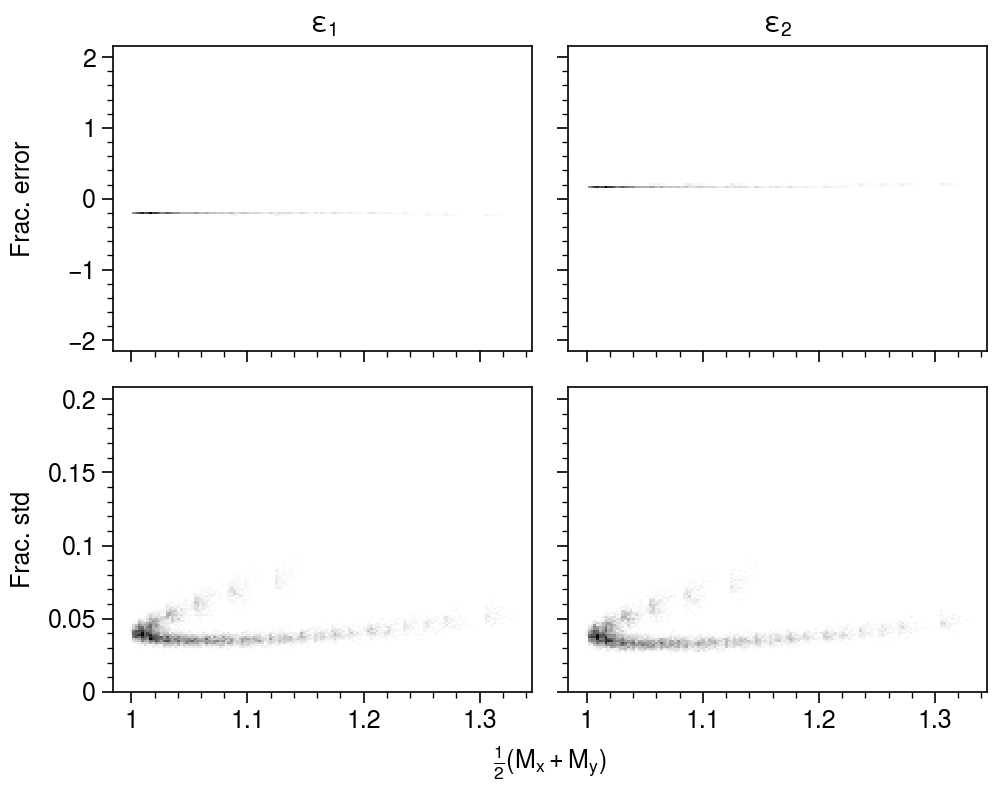

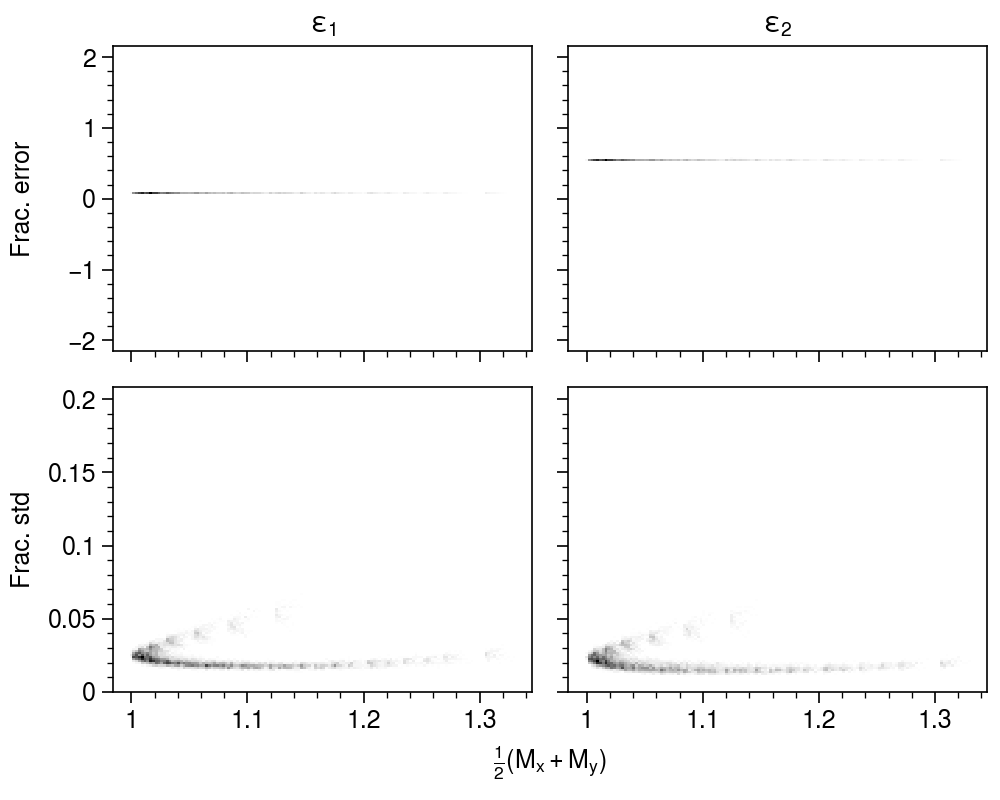

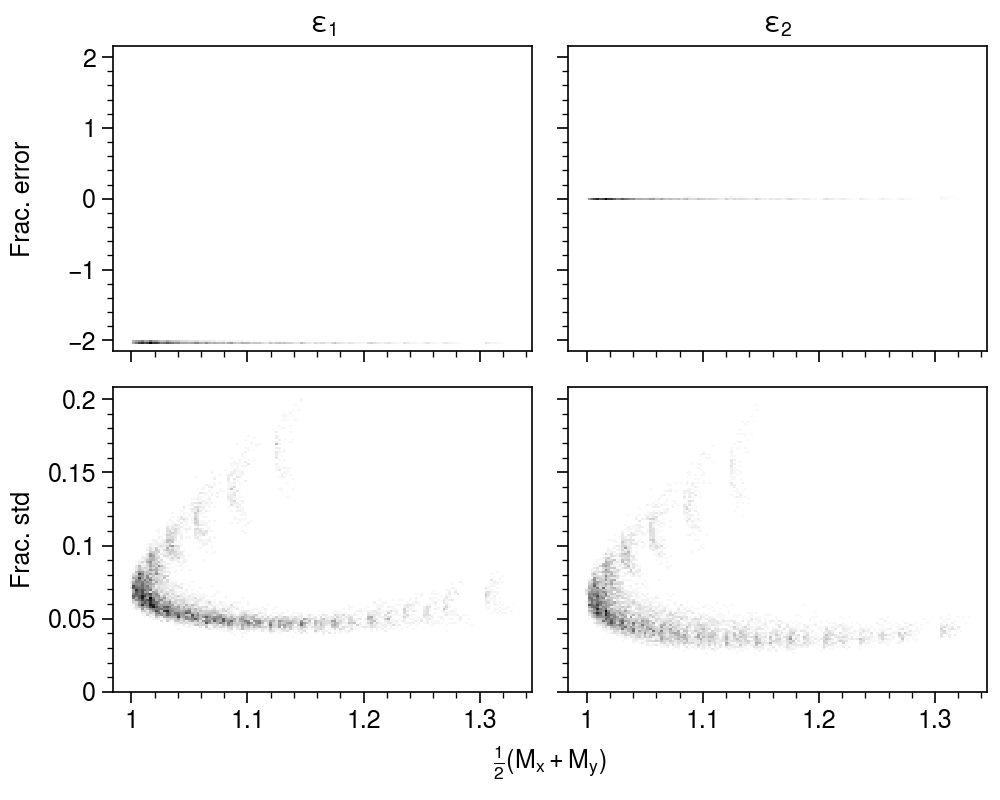

In [69]:
for k in range(4):
    fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0), 
                          sharey=False, spany=False, aligny=True)
    x = 0.5 * M.ravel()
    for j in range(2):
        for i, data in enumerate([frac_errs[k], frac_stds[k]]):
            y = data[..., j + 2].values.ravel()
            sns.histplot(ax=axes[i, j], x=x, y=y, binrange=[xlims[i, j], ylims[i, j]],
                         cmap='mono', bins=150, thresh=None,
                        )
    axes.format(xlabel=r'$\frac{1}{2} (M_x + M_y)$')
    axes[0, 0].format(ylabel='Frac. error')
    axes[1, 0].format(ylabel='Frac. std')

    for ax, label in zip(axes[0, :], eps_labels[2:]):
        ax.set_title(label)
    axes[:, 1].format(yticklabels=[])
    plt.savefig(f'_output/figures/mismatch2_{k}.png', dpi=400)
    plt.show()

In [ ]:
frac_errs.isel(alpha_x=-1, beta_x=-1, beta_y=-1, alpha_y=0)